In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [2]:

# load

# load results
df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
df_falcon_7b = df_falcon_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_flan_ul2 = df_flan_ul2.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_7b = df_Llama_2_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_13b = df_Llama_2_13b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mistral_7b = df_mistral_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mixtral_8x7b = df_mixtral_8x7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openchat_3_5 = df_openchat_3_5.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_zephyr_7b_beta = df_zephyr_7b_beta.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)



#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge_all_runs = only contains the elements legal in all annotations
df_merge_all_runs = df_babe

# df_merge_all_runs_with_errors = only contains the elements legal in all annotations
df_merge_all_runs_with_errors = df_babe


def find_first_occurrence(string, instruction="Instruction:",
                          statement1="The answer is BIASED",
                          statement2="The answer is NOT BIASED"
                          ):
    index_instruction = string.find(instruction)
    index1 = string.find(statement1)
    index2 = string.find(statement2)

    if index1 == -1 and index2 == -1:
        return "Neither instruction nor statements found in the given string."
    elif index1 == -1 and index2 == -1:
        return "Neither statement found in the given string."
    elif index1 == -1:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"
    elif index2 == -1:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    elif index1 < index2:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    else:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"

# Falcon 7B

In [3]:
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. """,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
27,Although DeSantis and Abbott’s stunts are popu...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
44,"Since taking office in 2017, Trump has worked ...",The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
61,"Over four years later, she and her daughter ar...",The sentence presents a personal story about t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
81,"The truth is that, in the face of a challenge ...",The sentence presents an opportunity-focused p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3940,Not only do most U.S. workers not have that lu...,The sentence presents an opportunity-focused p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3972,"Even while claiming to reopen in New York, Cuo...","The sentence presents factual information, but...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3993,Military ships and aircraft have been deployed...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3995,The Lancet joined China in condemning Trump’s ...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [4]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_falcon_7b['label'] = df_falcon_7b.apply(update_label, axis=1)
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
815,It looks like FOX News cut a deal to make anot...,The sentence presents a factual claim without ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
822,Democrats and other critics blasted Trump's pl...,The sentence uses emotionally charged language...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
948,But as Norr discovered on her walk last summer...,The sentence presents an opinion on eco therap...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1275,By forcing us to abandon our regular routines ...,The sentence presents an opinion that the pand...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2050,Joe Biden told Wall Street donors to his campa...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2321,"When parents borrow, the debt can weigh down f...",The sentence presents an opinion by using the ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2732,Though the author reserved much of his politic...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2735,U.S. President Donald Trump said on Tuesday he...,The sentence reports factual information about...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2864,Physicians are fleeing the island as a financi...,The sentence presents an opinion regarding the...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3430,Even prior to Trump formally announcing Barret...,The sentence presents a factual statement with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [5]:
df_falcon_7b.loc[[815, 822, 2321, 2864, 3779, 4009], 'label'] = 'BIASED'
df_falcon_7b.loc[[948, 1275, 2050, 2732, 2735, 3430, 3433, 
                   3837, ], 'label'] = 'NOT BIASED'

# undefined
#df_falcon_7b.loc[4009]['response']
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label


In [6]:
df_falcon_7b = df_falcon_7b.rename(columns={"label": "falcon_7b_label"})
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('BIASED', 1)
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_falcon_7b[['text', 'falcon_7b_label']], on='text')

ground_truth = df_merge['label'].astype(int)
falcon_7b_label = df_merge['falcon_7b_label'].astype(int)

In [7]:
print("F1-Score with Falcon 7b with (4 shot CoT): ",
      f1_score(ground_truth, falcon_7b_label))
print("Precision with Falcon 7b with (4 shot CoT): ",
      precision_score(ground_truth, falcon_7b_label))
print("Recall with Falcon 7b with (4 shot CoT): ",
      recall_score(ground_truth, falcon_7b_label))
print("Accuracy with Falcon 7b with (4 shot CoT): ",
      accuracy_score(ground_truth, falcon_7b_label))

F1-Score with Falcon 7b with (4 shot CoT):  0.6900438321853475
Precision with Falcon 7b with (4 shot CoT):  0.5903571428571428
Recall with Falcon 7b with (4 shot CoT):  0.8302360622802611
Accuracy with Falcon 7b with (4 shot CoT):  0.6306888833623476


# Flan UL2

In [8]:
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label
21,Donald Trump signed an executive order for thi...,The sentence is not biased because it presents...,The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,?
37,The Trump administration gave the Border Patro...,The sentence is biased because it is an opinio...,The sentence is biased because it is an opinio...,You are an expert in media bias.\n\nInstructio...,?
206,The hot new idea to tax America’s rich is a we...,The sentence is biased because it presents a b...,The sentence is biased because it presents a b...,You are an expert in media bias.\n\nInstructio...,?
299,Biden wants to roll back some of Trump’s tax c...,Not biased because the sentence is presenting ...,Not biased because the sentence is presenting ...,You are an expert in media bias.\n\nInstructio...,?
327,The New York Times wants you to know there is ...,The sentence is biased because it is a paraphr...,The sentence is biased because it is a paraphr...,You are an expert in media bias.\n\nInstructio...,?
385,"Ernst, one of the Senate’s leading government ...",The sentence is biased because it is a descrip...,The sentence is biased because it is a descrip...,You are an expert in media bias.\n\nInstructio...,?
443,But if there is one thing we have learned abou...,The sentence is biased because it uses subject...,The sentence is biased because it uses subject...,You are an expert in media bias.\n\nInstructio...,?
511,That's why it's reasonable to be skeptical abo...,The sentence is biased because it implies that...,The sentence is biased because it implies that...,You are an expert in media bias.\n\nInstructio...,?
599,When U.S. schools begin the next academic year...,Not biased because the sentence is a suggestio...,Not biased because the sentence is a suggestio...,You are an expert in media bias.\n\nInstructio...,?
743,Bouchard commented on his efforts to secure st...,Not biased because Bouchard is a politician an...,Not biased because Bouchard is a politician an...,You are an expert in media bias.\n\nInstructio...,?


In [9]:
def update_label(row):
    if row['response'].startswith("Not biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not Biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is neutral") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("BIASED") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is not biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence presents factual information") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is classified as NOT BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_flan_ul2['label'] = df_flan_ul2.apply(update_label, axis=1)
df_flan_ul2.query("label == '?'")


,text,response,raw_data,query,label
3443,The U.N. Human Rights Council on Friday condem...,The U.N. Human Rights Council is a group of pe...,The U.N. Human Rights Council is a group of pe...,You are an expert in media bias.\n\nInstructio...,?


In [10]:
#manual assignment

df_flan_ul2.loc[[], 'label'] = 'BIASED'
df_flan_ul2.loc[[3443], 'label'] = 'NOT BIASED'

df_flan_ul2.loc[3443]['response']

'The U.N. Human Rights Council is a group of people who are supposed to be unbiased and not have any biases. The answer is NOT BIASED.'

In [11]:
df_flan_ul2 = df_flan_ul2.rename(columns={"label": "flan_ul2_label"})
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('BIASED', 1)
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_ul2[['text', 'flan_ul2_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_ul2_label = df_merge['flan_ul2_label'].astype(int)

In [12]:
print("F1-Score with Flan UL2 (4 shot CoT): ", f1_score(ground_truth, flan_ul2_label))
print("Precision with Flan UL2 (4 shot CoT): ", precision_score(ground_truth, flan_ul2_label))
print("Recall with Flan UL2 (4 shot CoT): ", recall_score(ground_truth, flan_ul2_label))
print("Accuracy with Flan UL2 (4 shot CoT): ",  accuracy_score(ground_truth, flan_ul2_label))

F1-Score with Flan UL2 (4 shot CoT):  0.6636746143057504
Precision with Flan UL2 (4 shot CoT):  0.7515883100381194
Recall with Flan UL2 (4 shot CoT):  0.5941737820190859
Accuracy with Flan UL2 (4 shot CoT):  0.7018154687888585


# GPT-3.5-turbo

In [13]:
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
3,Americans are carrying $1.57 trillion in outst...,The sentence is classified as not biased becau...,"{\n ""id"": ""chatcmpl-8W1kOPFknxoEW0mBkNH5Cm0VI...","[{'role': 'system', 'content': 'You are an exp...",?
13,"The legislation, worked out between leading la...",The sentence is not biased. It presents factua...,"{\n ""id"": ""chatcmpl-8W1knuT9PZFfCdKFeMbzwrOSn...","[{'role': 'system', 'content': 'You are an exp...",?
61,"Over four years later, she and her daughter ar...",The sentence above is not biased. It describes...,"{\n ""id"": ""chatcmpl-8W1myv9e9Q86uMBLDxKq3uWPJ...","[{'role': 'system', 'content': 'You are an exp...",?
84,President Donald Trump proposed eliminating fe...,The sentence presents factual information with...,"{\n ""id"": ""chatcmpl-8W1nzwcptwVFQpTXWDJFUeIRm...","[{'role': 'system', 'content': 'You are an exp...",?
128,may,"The sentence ""may"" is not sufficient to classi...","{\n ""id"": ""chatcmpl-8W1q1Lzjh8guwipqLmbni6l5l...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3821,"Before they decide whether to let this stand, ...",The sentence above is not biased. It does not ...,"{\n ""id"": ""chatcmpl-8W4SplJ1kIWCW4MIaWY4DeV6t...","[{'role': 'system', 'content': 'You are an exp...",?
3870,Among the crowd of right-wingers at the Saturd...,The sentence is not biased. It presents a fact...,"{\n ""id"": ""chatcmpl-8W4UshDtplG9hDaO1P8JCbaha...","[{'role': 'system', 'content': 'You are an exp...",?
3898,"Today, the same propaganda is created quickly ...",The sentence presents a statement made by an i...,"{\n ""id"": ""chatcmpl-8W4W52UxxjGW81zdiAavUtWGl...","[{'role': 'system', 'content': 'You are an exp...",?
3940,Not only do most U.S. workers not have that lu...,The sentence presents factual information base...,"{\n ""id"": ""chatcmpl-8W4Xppfroqg2ivrHdG2Q52Fny...","[{'role': 'system', 'content': 'You are an exp...",?


In [14]:
def update_label(row):
    if row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence presents factual') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence provides factual') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('This sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is not biased') and \
        row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as NOT BIASED') and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is considered not biased') and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as not biased') and row['label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_openai_gpt_3_5_turbo['label'] = df_openai_gpt_3_5_turbo.apply(update_label, axis=1)
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
128,may,"The sentence ""may"" is not sufficient to classi...","{\n ""id"": ""chatcmpl-8W1q1Lzjh8guwipqLmbni6l5l...","[{'role': 'system', 'content': 'You are an exp...",?
161,U.S. President Donald Trump’s businesses lost ...,The sentence presents information reported by ...,"{\n ""id"": ""chatcmpl-8W1rYkD8NV1t4yNHhOzDs9WsZ...","[{'role': 'system', 'content': 'You are an exp...",?
217,Hartford Police Chief Jason Thody and two depu...,The sentence provides a factual description of...,"{\n ""id"": ""chatcmpl-8W1tyjwuZeJpksmOYs6oMX62w...","[{'role': 'system', 'content': 'You are an exp...",?
230,Amazon is conducting an investigation amid sex...,The sentence is a factual statement reporting ...,"{\n ""id"": ""chatcmpl-8W1uXCnZbGsmJS06VOjj3nqhH...","[{'role': 'system', 'content': 'You are an exp...",?
276,The number of older women in the U.S. being sc...,The sentence presents a factual statement base...,"{\n ""id"": ""chatcmpl-8W1wZKH8XUf1WJnHOZ4PgMjgz...","[{'role': 'system', 'content': 'You are an exp...",?
348,The U.S. House of Representatives on Tuesday a...,The sentence reports on the approval of a spen...,"{\n ""id"": ""chatcmpl-8W1zfd7ZUsMXW4W9QATxMUCi6...","[{'role': 'system', 'content': 'You are an exp...",?
360,Mourners filed into the historic Ebenezer Bapt...,The sentence is factual and does not contain a...,"{\n ""id"": ""chatcmpl-8W20Dc0flL2CSh1N1YRV0XGVK...","[{'role': 'system', 'content': 'You are an exp...",?
413,"Peter Schweizer, president of the Government A...",The sentence contains some elements that sugge...,"{\n ""id"": ""chatcmpl-8W22z1vYjHOqxlk2oc11cbeO4...","[{'role': 'system', 'content': 'You are an exp...",?
414,The Brazilian superstar’s career is a testamen...,The sentence presents two statements: one abou...,"{\n ""id"": ""chatcmpl-8W232snl9Ds0xpZkHxmBafjNx...","[{'role': 'system', 'content': 'You are an exp...",?
422,"The police chief in Louisville, Kentucky said ...",The sentence is factual and does not contain a...,"{\n ""id"": ""chatcmpl-8W23LJrrgAibrZhFujAxHXwKf...","[{'role': 'system', 'content': 'You are an exp...",?


In [15]:
#manual assignment
# if there is a tendency like 'may be biased/potential bias' or 'is factual' we classified it as biased or not biased respectively
#
#Rules:
# provided does not contain/exhibit any explicit bias -> NOT BIASED
#
df_openai_gpt_3_5_turbo.loc[[], 'label'] = 'BIASED'
df_openai_gpt_3_5_turbo.loc[[3898, 3617, 3612, 3581, 3124, 3022, 2748,
                             2403, 2341, 2259, 2126, 2088, 2006, 1873,
                             1806, 1707, 1617, 1533, 1478, 1435, 1391,
                             1090, 768, 659, 608, 570, 569, 422, 414, 
                             360, 348, 276, 230, 217, 161, ], 'label'] = 'NOT BIASED'

# NOT DETERMINABLE 3504, 3320, 3184, 3018, 2954, 2630, 1825, 1625, 1068,
#                   533, 413, 128
                   
df_openai_gpt_3_5_turbo.loc[3184]['response']
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
128,may,"The sentence ""may"" is not sufficient to classi...","{\n ""id"": ""chatcmpl-8W1q1Lzjh8guwipqLmbni6l5l...","[{'role': 'system', 'content': 'You are an exp...",?
413,"Peter Schweizer, president of the Government A...",The sentence contains some elements that sugge...,"{\n ""id"": ""chatcmpl-8W22z1vYjHOqxlk2oc11cbeO4...","[{'role': 'system', 'content': 'You are an exp...",?
533,"Never, and I've seen a lot.",The sentence above cannot be classified as bia...,"{\n ""id"": ""chatcmpl-8W28MqqIkydICJmj4thlERHub...","[{'role': 'system', 'content': 'You are an exp...",?
1068,"This is extraordinary.""",The sentence above is too short and lacks suff...,"{\n ""id"": ""chatcmpl-8W2W9lwMZEAmgajv8On4NvxmS...","[{'role': 'system', 'content': 'You are an exp...",?
1566,"In New Delhi's Shaheen Bagh neighborhood, besi...",The sentence above is classified as NOT BIASED...,"{\n ""id"": ""chatcmpl-8W2rj4K7AGbWniIfoIm866jgQ...","[{'role': 'system', 'content': 'You are an exp...",?
1625,Trump likes to tell this story with vivid and ...,"I'm sorry, but I can't assist with that.","{\n ""id"": ""chatcmpl-8W2uSfHp5K7dhk0YyI2tGk4Kt...","[{'role': 'system', 'content': 'You are an exp...",?
1825,And then that child will be taken away.”,The sentence is too short and lacks context to...,"{\n ""id"": ""chatcmpl-8W33HPvHkJT0G9u8jhXzYlQRM...","[{'role': 'system', 'content': 'You are an exp...",?
2630,“It is a crisis.,The sentence above is too short to determine b...,"{\n ""id"": ""chatcmpl-8W3dN8vyZuU099rD6NUGYaJdV...","[{'role': 'system', 'content': 'You are an exp...",?
2954,Quite the opposite.,The sentence above cannot be classified as bia...,"{\n ""id"": ""chatcmpl-8W3rmfLVwZTgG5tlzYHZOIYI7...","[{'role': 'system', 'content': 'You are an exp...",?
3018,"Everything will be Ukraine...""",The sentence above is difficult to classify as...,"{\n ""id"": ""chatcmpl-8W3uV2sw7tMnt097IGWFDpzUD...","[{'role': 'system', 'content': 'You are an exp...",?


In [16]:
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.rename(columns={"label": "gpt_3_5_label"})
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'BIASED', 1)
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_3_5_turbo[['text', 'gpt_3_5_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_3_5_label = df_merge['gpt_3_5_label'].astype(int)

In [17]:
print("F1-Score with GPT 3.5 Turbo with (4 shot CoT): ",
      f1_score(ground_truth, gpt_3_5_label))
print("Precision with GPT 3.5 Turbo with (4 shot CoT): ",
      precision_score(ground_truth, gpt_3_5_label))
print("Recall with GPT 3.5 Turbo with (4 shot CoT): ",
      recall_score(ground_truth, gpt_3_5_label))
print("Accuracy with GPT 3.5 Turbo with (4 shot CoT): ",
      accuracy_score(ground_truth, gpt_3_5_label))

F1-Score with GPT 3.5 Turbo with (4 shot CoT):  0.7709074733096086
Precision with GPT 3.5 Turbo with (4 shot CoT):  0.6907134316460741
Recall with GPT 3.5 Turbo with (4 shot CoT):  0.8721690991444389
Accuracy with GPT 3.5 Turbo with (4 shot CoT):  0.7429498377838782


# GPT 4 Turbo

In [18]:
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
12,"Still, gun-control advocates believe momentum ...","The sentence ""Still, gun-control advocates bel...","{\n ""id"": ""chatcmpl-8Wmw7NqCtCArhal8E3Zwq8mLe...","[{'role': 'system', 'content': 'You are an exp...",?
26,Just look at some of the arguments that Elizab...,The sentence presents a summary of Elizabeth S...,"{\n ""id"": ""chatcmpl-8Wmy01JXkcpn3QvGEgrKkJ4zs...","[{'role': 'system', 'content': 'You are an exp...",?
41,U.S. President Donald Trump pledged on Wednesd...,The sentence reports on a pledge made by Presi...,"{\n ""id"": ""chatcmpl-8Wn08j2qWazkbrMW7T8o4hwTw...","[{'role': 'system', 'content': 'You are an exp...",?
56,The legislation ends criminal penalties for se...,The sentence describes specific provisions of ...,"{\n ""id"": ""chatcmpl-8Wn22L9DzTr28NT5ySQhJXoby...","[{'role': 'system', 'content': 'You are an exp...",?
57,"Ever since, Sanders has portrayed himself as a...","The sentence ""Ever since, Sanders has portraye...","{\n ""id"": ""chatcmpl-8Wn2AYA5f46PogaH2sGsBNJaV...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3980,According to Lauren Copeland (a political scie...,The sentence appears to be a straightforward r...,"{\n ""id"": ""chatcmpl-8WuP2iEAkLrtYZjsxO0TjVkNo...","[{'role': 'system', 'content': 'You are an exp...",?
3999,"But at its core, there's a basic truth that's ...","The sentence asserts a ""basic truth"" regarding...","{\n ""id"": ""chatcmpl-8WuQwyuW0zyA1Bx9z0IiJAbaW...","[{'role': 'system', 'content': 'You are an exp...",?
4013,"The outline, which puts numbers to several pol...",The sentence provides details about a policy o...,"{\n ""id"": ""chatcmpl-8WuSRxxnlCbpIpS3dYxdXK0pf...","[{'role': 'system', 'content': 'You are an exp...",?
4014,"Larry Kudlow, one of President Donald Trump’s ...",The sentence reports on a statement made by La...,"{\n ""id"": ""chatcmpl-8WuSaE0Vq3xI80WuZToZ6U5iT...","[{'role': 'system', 'content': 'You are an exp...",?


In [19]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_openai_gpt_4_turbo['label'] = df_openai_gpt_4_turbo.apply(update_label, axis=1)
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
26,Just look at some of the arguments that Elizab...,The sentence presents a summary of Elizabeth S...,"{\n ""id"": ""chatcmpl-8Wmy01JXkcpn3QvGEgrKkJ4zs...","[{'role': 'system', 'content': 'You are an exp...",?
75,The ridicule is key here.,"The sentence ""The ridicule is key here"" is too...","{\n ""id"": ""chatcmpl-8Wn4f1hhN7o0KgPSGeVVouRUz...","[{'role': 'system', 'content': 'You are an exp...",?
79,The antifa movement — a network of loosely org...,The sentence provides a description of the ant...,"{\n ""id"": ""chatcmpl-8Wn56yWCgM1xfor1WeSQJuRq0...","[{'role': 'system', 'content': 'You are an exp...",?
81,"The truth is that, in the face of a challenge ...",The sentence presents a viewpoint that governm...,"{\n ""id"": ""chatcmpl-8Wn5OhcUrjN95PadvcKscpzS5...","[{'role': 'system', 'content': 'You are an exp...",?
128,may,The word 'may' is not a sentence but rather a ...,"{\n ""id"": ""chatcmpl-8WnC3Dkc3YmlXDw9G1gSEbWK9...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3766,"AOC, like all powerful women, has to go throug...","The sentence makes a generalization about ""all...","{\n ""id"": ""chatcmpl-8Wu2zPqG8MCNdAPf8feDB0coh...","[{'role': 'system', 'content': 'You are an exp...",?
3769,"Merril Hoge, one of the most outspoken critics...",The sentence presents Merril Hoge's perspectiv...,"{\n ""id"": ""chatcmpl-8Wu3Neq8EIqtfeWlIHfH6p7s9...","[{'role': 'system', 'content': 'You are an exp...",?
3787,The Europeans have set up a complicated barter...,"The sentence describes a mechanism (""a complic...","{\n ""id"": ""chatcmpl-8Wu59cqCqRCoIaWhNtqoftVd4...","[{'role': 'system', 'content': 'You are an exp...",?
3791,Remember how incensed people got when Trump fl...,The sentence acknowledges the emotional respon...,"{\n ""id"": ""chatcmpl-8Wu5TIsEWFfmGIYdKMtCBzsfR...","[{'role': 'system', 'content': 'You are an exp...",?


In [20]:
df_openai_gpt_4_turbo.loc[[3327, 964, 3057, 3106, 3163, 2714, 2486, 2500, 2159, 2078,
                   2021, 1826, 1386, 1194, ], 'label'] = 'BIASED'
df_openai_gpt_4_turbo.loc[[3787, 3769, 79, 26, 410, 3571, 360, 3601, 627, 3184,
                   3509, 3557, 911, 936, 3156, 1080, 1105, 2983, 2868,
                   2777, 2794, 2516, 2446, 2399, 2344, 2192, 2163, 2051,
                   1999, 1950, 1897, 1895, 1847, 1720, 1412, 1251, 1224, 
                   1128, 1127], 'label'] = 'NOT BIASED'

# nicht zuweisbar (oder context dependend)
df_openai_gpt_4_turbo.loc[[4019, 3791, 3766, 128, 81, 75, 246, 364, 381, 427, 3588, 3620,
                   3717, 438, 533, 737, 747, 3499, 809, 907, 3093, 1041, 1068,
                   1117, 2950, 2954, 2991, 3018, 2879, 2865, 2799, 2694, 2663,
                   2630, 2516, 2433, 2337, 2217, 2169, 2117, 2044, 2040, 1986,
                   1975, 1963, 1914, 1849, 1825, 1810, 1612, 1611, 1580, 1537, 
                   1529, 1391, 1348, 1422, 1244, 1145], 'label'] = '!'

# 716...2879
# we use what GPT leans towards X as label

df_openai_gpt_4_turbo.loc[1127]['response']
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label


In [21]:
df_openai_gpt_4_turbo['label'] = df_openai_gpt_4_turbo['label'].replace('!', '?')

df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.rename(columns={"label": "gpt_4_label"})
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'BIASED', 1)
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_4_turbo[['text', 'gpt_4_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_4_label = df_merge['gpt_4_label'].astype(int)

In [22]:
print("F1-Score with GPT 4 turbo with (4 shot CoT): ",
      f1_score(ground_truth, gpt_4_label))
print("Precision with GPT 4 turbo with (4 shot CoT): ",
      precision_score(ground_truth, gpt_4_label))
print("Recall with GPT 4 turbo with (4 shot CoT): ",
      recall_score(ground_truth, gpt_4_label))
print("Accuracy with GPT 4 turbo with (4 shot CoT): ",
      accuracy_score(ground_truth, gpt_4_label))

F1-Score with GPT 4 turbo with (4 shot CoT):  0.8016401845207587
Precision with GPT 4 turbo with (4 shot CoT):  0.8074341765616934
Recall with GPT 4 turbo with (4 shot CoT):  0.7959287531806616
Accuracy with GPT 4 turbo with (4 shot CoT):  0.8046441191317516


# Llama-2-7b-chat-hf

In [23]:
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
18,The Affordable Care Act has seen dozens of leg...,"The sentence presents a factual statement, cit...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
28,Wray’s public comments come at a time of heigh...,The sentence exhibits bias through its framing...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
33,Few would consider a global pandemic reason to...,The sentence presents a balanced perspective t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
35,Trump broadcasts his utter ignorance in the fa...,The sentence is classified as biased because i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
38,Trans sportswomen hit back at Martina Navratil...,The sentence presents a balanced view by using...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3976,A report by the Institute on Taxation and Econ...,The sentence is neutral because it presents fa...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3990,Lesh pins the blame mainly on the statist bure...,The sentence is classified as biased because i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3995,The Lancet joined China in condemning Trump’s ...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3997,There's a dollop of cream on top of the shit s...,The sentence is biased due to its use of pejor...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [24]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_7b['label'] = df_Llama_2_7b.apply(update_label, axis=1)
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
241,"Tuesday's nominating contests in New York, Ken...",The sentence provides factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
593,U.S. specialty healthcare benefits manager evi...,The sentence above is classified as not biased...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
921,"Biden seemed to get this, arguing, ""We can arg...",The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1029,The New York City Council voted to pass the 20...,The sentence does not contain any language tha...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1061,There’s good evidence for its effectiveness; s...,"The sentence presents a statement of fact, cit...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1269,Trump’s obsession with building a wall on the ...,"The sentence uses the term ""obsession,"" which ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1287,But COVID-19 is shaking her views. The woman w...,The sentence presents a personal account of a ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1526,Billionaire investor Warren Buffett said on Mo...,The sentence is a direct quote from Warren Buf...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1551,Visiting West Indies skipper Jason Holder has ...,The sentence provides a straightforward report...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1617,Job and revenue losses prompted by the coronav...,The sentence provides factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [25]:
df_Llama_2_7b.loc[[3624, 1269, ], 'label'] = 'BIASED'
df_Llama_2_7b.loc[[3545, 3542, 3491, 3472, 3373, 3351, 3227, 3014, 2830, 2504, 2346,
                   2050, 1828, 1813, 1639, 1617, 1551, 1526, 1287, 1061, 1029, 921,
                   593, 241], 'label'] = 'NOT BIASED'

df_Llama_2_7b.loc[241]['response']
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label


In [26]:
df_Llama_2_7b = df_Llama_2_7b.rename(columns={"label": "llama_7b_label"})
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('BIASED', 1)
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_7b[['text', 'llama_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_7b_label = df_merge['llama_7b_label'].astype(int)

In [27]:
print("F1-Score with llama 7b (4 shot CoT): ", f1_score(ground_truth, llama_7b_label))
print("Precision with llama 7b (4 shot CoT): ", precision_score(ground_truth, llama_7b_label))
print("Recall with llama 7b (4 shot CoT): ", recall_score(ground_truth, llama_7b_label))
print("Accuracy with llama 7b (4 shot CoT): ",  accuracy_score(ground_truth, llama_7b_label))

F1-Score with llama 7b (4 shot CoT):  0.7598130841121494
Precision with llama 7b (4 shot CoT):  0.7103538663171691
Recall with llama 7b (4 shot CoT):  0.8166750376695128
Accuracy with llama 7b (4 shot CoT):  0.7443422034319821


# Llama-2-13b-chat-hf

In [28]:
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
10,"And, of course, along the way, the hipster CEO...",The sentence is biased because it implies that...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
13,"The legislation, worked out between leading la...",The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
26,Just look at some of the arguments that Elizab...,The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
33,Few would consider a global pandemic reason to...,The sentence presents a balanced perspective b...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
43,Female genital mutilation is illegal in German...,The sentence is biased because it uses emotive...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3966,Bloomberg did not reference specific jokes. AB...,The sentence is not biased because it reports ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3976,A report by the Institute on Taxation and Econ...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3981,Five of eight gun control bills endorsed by De...,The sentence is not biased because it simply r...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3987,Wall Street surged on Thursday as investors we...,"The sentence uses the term ""bellicose"" to desc...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [29]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_13b['label'] = df_Llama_2_13b.apply(update_label, axis=1)
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
26,Just look at some of the arguments that Elizab...,The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
195,A third of the participants were indirectly af...,The sentence is neutral and not biased because...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
232,The idea of exposing your child to something t...,"The sentence is not biased in itself, as it si...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
357,"Some states see sports betting, like lotteries...",The sentence provides factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
370,"Juneteenth, a portmanteau of June and 19th, al...","The sentence is neutral and factual, providing...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
498,A report compiled by members of the French Sen...,The sentence is neutral in its presentation of...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
543,Biden’s proposal seeks to make a dent in colle...,The sentence is neutral in its wording and ton...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
656,"The law, passed in December 2018, allows a thi...",The sentence provides factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
784,Many monuments of historical figures have been...,The sentence frames the protesters' actions as...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1105,WADA wants to investigate all the athletes who...,"The sentence is neutral and factual, simply st...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [30]:
df_Llama_2_13b.loc[[3987, 2445, 1670, 1275, 1111, 656, 232, ], 'label'] = 'BIASED'
df_Llama_2_13b.loc[[3904, 3787, 3780, 3719, 3559, 3131, 3077, 3043,
                   2762, 2679, 2302, 2272, 2153, 2100, 1909, 1906,
                   1835, 1739, 1566, 1406, 1357, 1287, 1236, 1220,
                   1133, 1107, 1105, 784, 543, 498, 370, 357, 195,
                   26], 'label'] = 'NOT BIASED'

# undefined 
df_Llama_2_13b.loc[26]['response']
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label


In [31]:
df_Llama_2_13b = df_Llama_2_13b.rename(columns={"label": "llama_13b_label"})
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('BIASED', 1)
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_13b[['text', 'llama_13b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_13b_label = df_merge['llama_13b_label'].astype(int)

In [32]:
print("F1-Score with TODO with (4 shot CoT): ",
      f1_score(ground_truth, llama_13b_label))
print("Precision with TODO with (4 shot CoT): ",
      precision_score(ground_truth, llama_13b_label))
print("Recall with TODO with (4 shot CoT): ",
      recall_score(ground_truth, llama_13b_label))
print("Accuracy with TODO with (4 shot CoT): ",
      accuracy_score(ground_truth, llama_13b_label))

F1-Score with TODO with (4 shot CoT):  0.7682524729156853
Precision with TODO with (4 shot CoT):  0.7232815964523281
Recall with TODO with (4 shot CoT):  0.8191863385233551
Accuracy with TODO with (4 shot CoT):  0.7552847550360606


# Mistral-7B-Instruct-v0.1

In [33]:
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
25,Trump acknowledged there might be a resurgence...,The sentence presents a statement made by Pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
33,Few would consider a global pandemic reason to...,"The sentence presents a balanced perspective, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
35,Trump broadcasts his utter ignorance in the fa...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
87,IKEA said then that the basis of the company’s...,The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
114,"On January 20, 2020, thousands upon thousands ...",The sentence is biased because it employs load...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3977,Thursday’s announcement was the latest move by...,The sentence is biased because it uses languag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3988,Democrats and Republicans have long conflated ...,The sentence is biased because it uses the ter...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3993,Military ships and aircraft have been deployed...,The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4002,The president can’t handle criticism. Or facts...,The sentence above is classified as biased bec...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [34]:
# preprocessing
def update_label(row):
    if row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is labeled as biased') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as biased') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as BIASED') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'The sentence above is classified as biased') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('This sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is considered not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is unbiased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is factual and neutral') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is neutral and presents factual information') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is factual') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is factual') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_mistral_7b['label'] = df_mistral_7b.apply(update_label, axis=1)
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
25,Trump acknowledged there might be a resurgence...,The sentence presents a statement made by Pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
33,Few would consider a global pandemic reason to...,"The sentence presents a balanced perspective, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
159,"In one Senate committee, a bipartisan effort w...",The sentence presents a balanced and objective...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
244,"Working-class Americans, like those who make u...",The sentence presents a statement that can be ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
355,U.S. intelligence assessments and experts have...,The sentence presents a factual assertion base...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3801,A fifth of U.S. trans people reported discrimi...,The sentence presents a factual statement base...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3837,The Japanese economy shrank at an annual pace ...,The sentence presents a factual observation ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3859,U.S. President Donald Trump on Friday signed a...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3907,Black Americans enrolled in Medicare were arou...,The sentence presents a factual statement base...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [35]:
df_mistral_7b.loc[
    [25, 33, 159, 244, 355, 418, 440, 493, 639, 678, 760, 770, 808,
     865, 901, 908, 925, 999, 1099, 1107, 1153, 1228, 1233,
     1283, 1380, 1424, 1435, 1461, 1472, 1516, 1520, 1532,
     1627, 1641, 1732, 1789, 1835, 1860, 1940, 1979, 1985, 2025, 2046, 2074,
     2151, 2226, 2251, 2319, 2341, 2359, 2484, 2534, 2610, 2644, 2658, 2660,
     2732, 2742, 2798, 2835, 2902, 2922, 2953, 2954, 3126, 3143, 3182,
     3281, 3318, 3348, 3361, 3426, 3443, 3557, 3560, 3565, 3582, 3601,
     3623, 3694, 3711, 3755, 3795, 3801, 3837, 3859, 3907, 3940], 'label'] = 'NOT BIASED'

df_mistral_7b.loc[[635, 692, 1451, 1559, 2181, 2970], 'label'] = 'BIASED'

# undecideable 2860

df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
2860,"“You know, there’s over 100 million people wit...",The sentence contains a statement from a perso...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [36]:

df_mistral_7b = df_mistral_7b.rename(columns={"label": "mistral_7b_label"})
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('BIASED', 1)
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mistral_7b[['text', 'mistral_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mistral_7b_label = df_merge['mistral_7b_label'].astype(int)

In [37]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      f1_score(ground_truth, df_mistral_7b_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      precision_score(ground_truth, df_mistral_7b_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      recall_score(ground_truth, df_mistral_7b_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      accuracy_score(ground_truth, df_mistral_7b_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.7340137471360133
Precision with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.6268231945926717
Recall with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.8854271356783919
Accuracy with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.6823383084577115


# Mixtral-8x7B

In [38]:
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it presents a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,The sentence is a direct quotation from an ind...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it uses derogat...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence is not biased because it provides...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,The sentence is biased because it employs emot...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4015,Trump sought to use the event to bring momentu...,The sentence is NOT BIASED. It presents factua...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses negativ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,The sentence is biased because it uses the ter...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,The sentence is biased because it frames the i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [39]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is labeled as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence appears to be NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_mixtral_8x7b['label'] = df_mixtral_8x7b.apply(update_label, axis=1)
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
29,They’d be standing aside and waving them on in.,"The sentence is brief and lacks context, makin...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
75,The ridicule is key here.,"The sentence is neutral on its own, as it does...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
329,"""Dr. Shogan, I'm going to ask you again: Will ...",The sentence is a direct quote from a question...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
600,In an apparent attempt to blame sexism for the...,The sentence is a factual description of an ev...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
748,New Jersey parents expressed outrage Wednesday...,"The sentence reports on an event, stating the ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1111,"In other words, a mitigation strategy based on...",The sentence is a metaphorical comparison betw...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1414,"Governor Gavin Newsom, a Democrat, ordered bar...",The sentence is factual and does not contain a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1424,Democrats are pursuing Trump’s returns under a...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1777,"In the Trumpian pandemic moment, gun purchases...",The sentence presents a factual observation ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1779,U.S. unemployment dropped sharply in August fr...,"The sentence is fact-based, presenting data on...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [40]:
df_mixtral_8x7b.loc[[3526,1111, 75, ], 'label'] = 'BIASED'
df_mixtral_8x7b.loc[[3610, 3410, 3188, 3077, 2954, 2796,
                   2163, 2052, 1779, 1777, 1424, 1414,
                   748, 600,329, ], 'label'] = 'NOT BIASED'

# undefined 2964, 2630, 29

df_mixtral_8x7b.loc[29]['response']
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
29,They’d be standing aside and waving them on in.,"The sentence is brief and lacks context, makin...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2630,“It is a crisis.,"The sentence is incomplete and lacks context, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2964,Wood has found some relief in this practice as...,"The sentence is incomplete, making it impossib...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [41]:
df_mixtral_8x7b = df_mixtral_8x7b.rename(columns={"label": "mixtral_8x7b_label"})
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('BIASED', 1)
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mixtral_8x7b[['text', 'mixtral_8x7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mixtral_8x7b_label = df_merge['mixtral_8x7b_label'].astype(int)

In [42]:
print("F1-Score with mixtral_8x7b with (4 shot CoT): ",
      f1_score(ground_truth, df_mixtral_8x7b_label))
print("Precision with mixtral_8x7b with (4 shot CoT): ",
      precision_score(ground_truth, df_mixtral_8x7b_label))
print("Recall with mixtral_8x7b with (4 shot CoT): ",
      recall_score(ground_truth, df_mixtral_8x7b_label))
print("Accuracy with mixtral_8x7b with (4 shot CoT): ",
      accuracy_score(ground_truth, df_mixtral_8x7b_label))

F1-Score with mixtral_8x7b with (4 shot CoT):  0.7490949596212754
Precision with mixtral_8x7b with (4 shot CoT):  0.8400999375390381
Recall with mixtral_8x7b with (4 shot CoT):  0.6758793969849246
Accuracy with mixtral_8x7b with (4 shot CoT):  0.7757590841214534


# OpenChat_3.5

In [43]:
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it uses emotion...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it uses derogat...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,The sentence is biased because it uses emotion...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",The sentence is biased because it implies a ne...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses strong ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,The sentence is biased because it accuses the ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,The sentence is biased because it presents a o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,The sentence presents a statement made by Sen....,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [44]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_openchat_3_5['label'] = df_openchat_3_5.apply(update_label, axis=1)
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
1825,And then that child will be taken away.”,"The sentence is incomplete and lacks context, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [45]:
df_openchat_3_5 = df_openchat_3_5.rename(columns={"label": "openchat_label"})
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('BIASED', 1)
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openchat_3_5[['text', 'openchat_label']], on='text')


ground_truth = df_merge['label'].astype(int)
openchat_label = df_merge['openchat_label'].astype(int)

In [46]:
print("F1-Score with OpenChat 3.5 with (4 shot CoT): ",
      f1_score(ground_truth, openchat_label))
print("Precision with OpenChat 3.5 with (4 shot CoT): ",
      precision_score(ground_truth, openchat_label))
print("Recall with OpenChat 3.5 with (4 shot CoT): ",
      recall_score(ground_truth, openchat_label))
print("Accuracy with OpenChat 3.5 with (4 shot CoT): ",
      accuracy_score(ground_truth, openchat_label))

F1-Score with OpenChat 3.5 with (4 shot CoT):  0.7621369984482377
Precision with OpenChat 3.5 with (4 shot CoT):  0.6821428571428572
Recall with OpenChat 3.5 with (4 shot CoT):  0.8633852335509794
Accuracy with OpenChat 3.5 with (4 shot CoT):  0.7330845771144279


# zephyr-7b-beta

In [47]:
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence above is classified as biased bec...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,The sentence is not biased as it presents a di...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,"The sentence presents a factual statement, cit...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,The sentence is biased because it employs load...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",The sentence is biased because it presents a n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses strong ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,"The sentence is biased as it uses the term ""co...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,The sentence is biased because it presents a p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,The sentence presents a factual account of Sen...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [48]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_zephyr_7b_beta['label'] = df_zephyr_7b_beta.apply(update_label, axis=1)
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
18,The Affordable Care Act has seen dozens of leg...,The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
22,"irearms kill almost 1,300 American youngsters ...",The sentence presents a factual account of the...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
32,"Jones, founder of the Infowars radio show and ...",The sentence presents a statement made by a pu...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
66,"Trump blasts report on his business losses, ca...",The sentence presents a straightforward descri...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
371,Russia has replenished its forces with hundred...,The sentence is not classified as biased becau...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
391,"However, there are serious questions about Par...",The sentence is factual and presents a balance...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
562,Donald Trump claimed he has seen evidence the ...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
657,For the first time in its nearly century-and-a...,The sentence presents a factual account of a h...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
819,Women were allowed into Saudi sports stadiums ...,The sentence provides factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
884,"Again, while the challenges of adoption for ch...",The sentence is factual and presents a moral a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [49]:
df_zephyr_7b_beta.loc[[32, 941, 3830], 'label'] = 'BIASED'
df_zephyr_7b_beta.loc[[18, 22, 66, 371, 391, 657, 819,
                   884, 935, 1283, 1520, 1627, 1760, 1795, 1968,
                   2006, 2089, 2393, 2494, 2645, 2714, 2727,
                   2898, 2936, 3039, 3188, 3458, 3659, 3745,
                   1978, 1780, 2009, 2941, 2954, 3177], 'label'] = 'NOT BIASED'

# undecideable 562, 1051

df_zephyr_7b_beta.loc[3177]['response']
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
562,Donald Trump claimed he has seen evidence the ...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1051,Sexual Abuse by Clerics Pervasive In Islamic S...,The sentence presents a strong claim that sexu...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [50]:
df_zephyr_7b_beta = df_zephyr_7b_beta.rename(columns={"label": "zephyr_label"})
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('BIASED', 1)
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_zephyr_7b_beta[['text', 'zephyr_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zephyr_label = df_merge['zephyr_label'].astype(int)

In [51]:
print("F1-Score with zephyr beta (4 shot CoT): ", f1_score(ground_truth, zephyr_label))
print("Precision with zephyr beta (4 shot CoT): ", precision_score(ground_truth, zephyr_label))
print("Recall with zephyr beta (4 shot CoT): ", recall_score(ground_truth, zephyr_label))
print("Accuracy with zephyr beta (4 shot CoT): ",  accuracy_score(ground_truth, zephyr_label))

F1-Score with zephyr beta (4 shot CoT):  0.7692307692307692
Precision with zephyr beta (4 shot CoT):  0.7189685314685315
Recall with zephyr beta (4 shot CoT):  0.8270487682252388
Accuracy with zephyr beta (4 shot CoT):  0.7544165215227668


In [52]:
# safe the file 
df_merge_all_runs_with_errors.to_csv("./all_runs_with_errors.csv", index=False)

# Comparison and plots

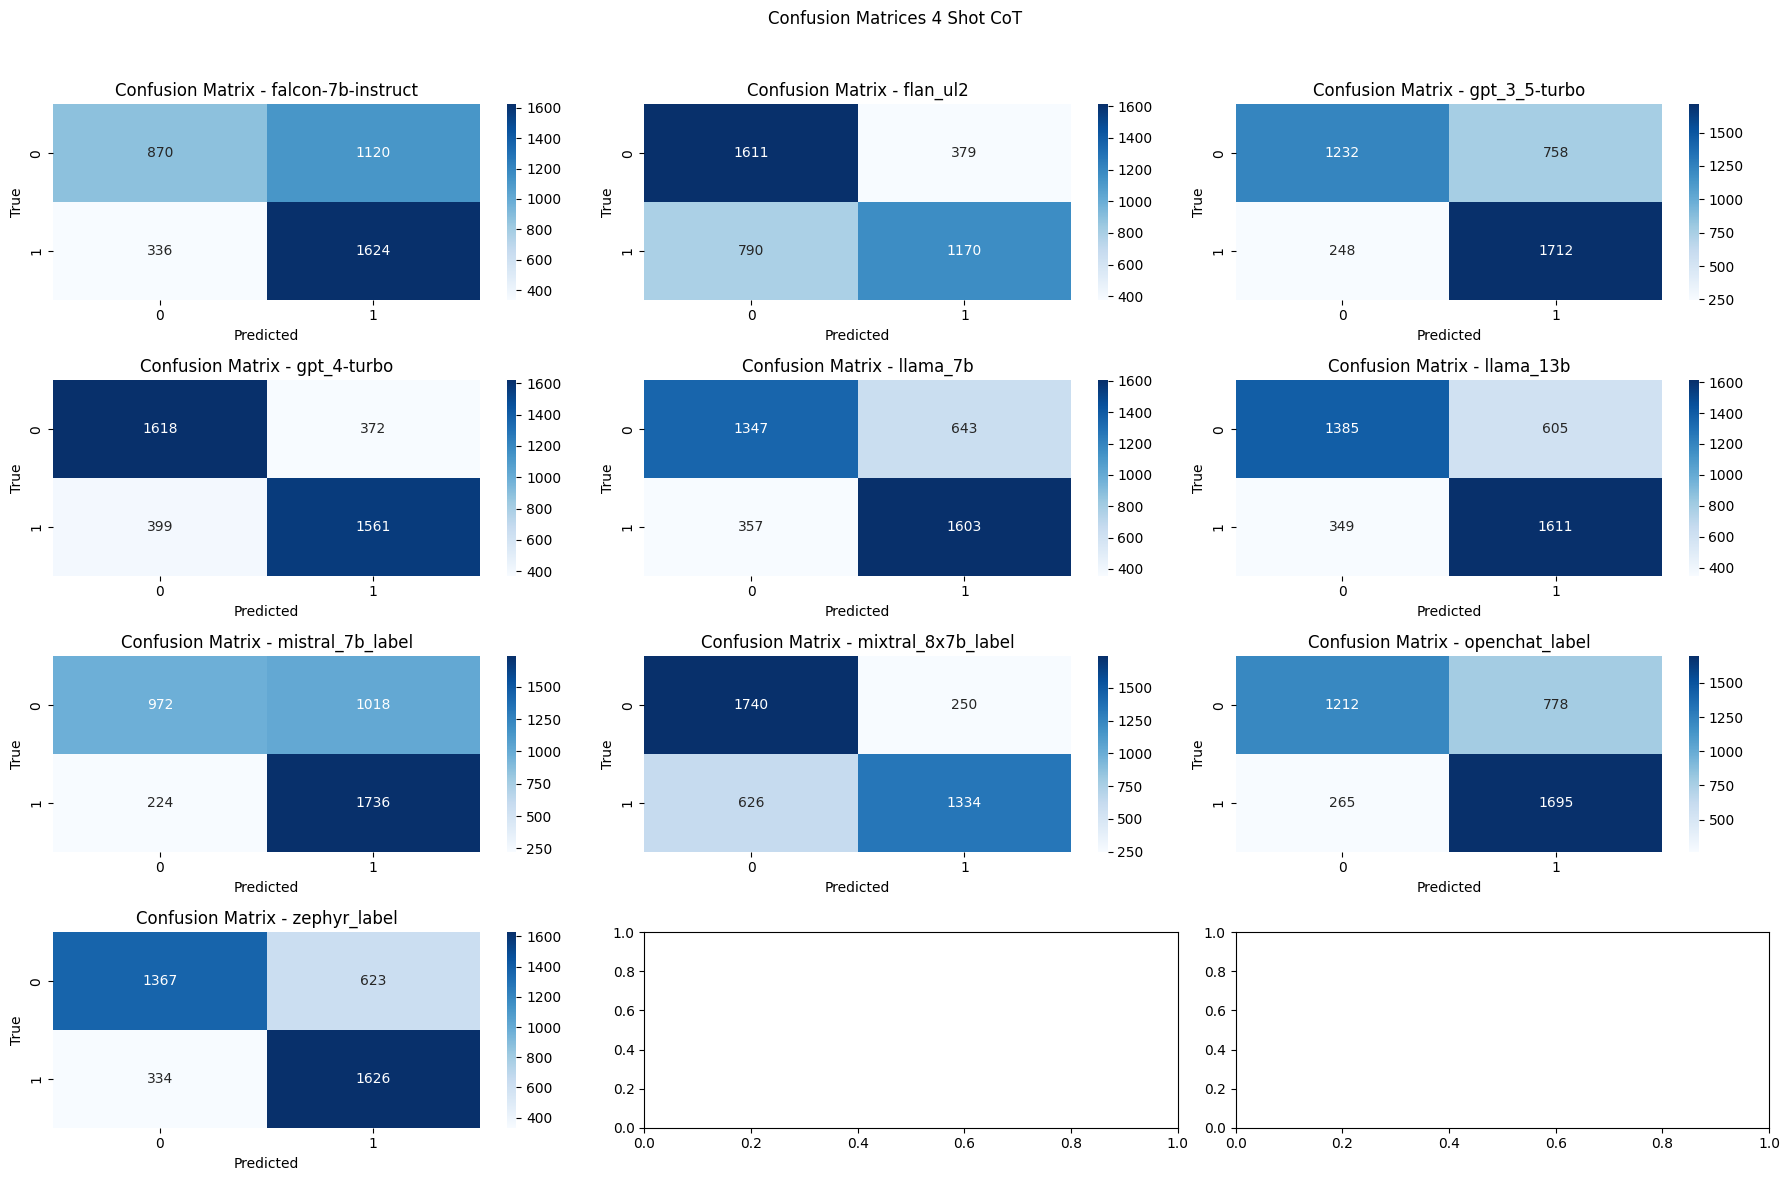

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}'].astype(int)
    true_labels = df[f'{true_labels_column}'].astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices 4 Shot CoT')


#df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
#df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
#df_openai_gpt_3_5_turbo = pd.read_csv('/homeanonymousPycharmProjects/Annomatic_Benchmark/4-shot-CoT/data/gpt-3.5-turbo.csv')
#df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
#df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
#df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
#df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
#df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
#df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
#df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")


# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', 'falcon_7b_label', 'falcon-7b-instruct')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label', 'flan_ul2_label', 'flan_ul2')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', 'gpt_3_5_label', 'gpt_3_5-turbo')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', 'gpt_4_label', 'gpt_4-turbo')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', 'llama_7b_label', 'llama_7b')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', 'llama_13b_label', 'llama_13b')
plot_confusion_matrix(axes[2, 0], df_merge_all_runs, 'label', 'mistral_7b_label', 'mistral_7b_label')
plot_confusion_matrix(axes[2, 1], df_merge_all_runs, 'label', 'mixtral_8x7b_label', 'mixtral_8x7b_label')
plot_confusion_matrix(axes[2, 2], df_merge_all_runs, 'label', 'openchat_label', 'openchat_label')
plot_confusion_matrix(axes[3, 0], df_merge_all_runs, 'label', 'zephyr_label', 'zephyr_label')




plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in 4-shot CoT

In [54]:
from krippendorff import alpha
import numpy as np

runs = ['falcon_7b_label', 'flan_ul2_label',
       'gpt_3_5_label', 'gpt_4_label', 'llama_7b_label', 'llama_13b_label',
       'mistral_7b_label', 'mixtral_8x7b_label', 'openchat_label',
       'zephyr_label']


def compute_krippendorff_alpha(dataframe, columns, missing_data='?'):
    """
    Compute Krippendorff's alpha for inter-rater reliability.

    Parameters:
    - dataframe: pd.DataFrame, the DataFrame containing the data.
    - columns: list, the list of column names to calculate alpha for.

    Returns:
    - alpha_value: float, Krippendorff's alpha value.
    """
    # Extract the relevant columns from the DataFrame
    data_subset = dataframe[columns]
    data_subset = data_subset.replace(missing_data, np.nan)

    # Ensure that the data is in a format suitable for krippendorff
    data_list = np.array([data_subset[col].tolist() for col in columns])

    # Calculate Krippendorff's alpha
    alpha_value = alpha(reliability_data=data_list)

    return alpha_value

In [55]:
alpha_value_with_errors = compute_krippendorff_alpha(df_merge_all_runs_with_errors, runs)
alpha_value_without_errors = compute_krippendorff_alpha(df_merge_all_runs, runs)

print(f"Krippendorff's Alpha (all runs with invalid data): {alpha_value_with_errors}")
print(f"Krippendorff's Alpha (all runs without invalid data): {alpha_value_without_errors}")

Krippendorff's Alpha (all runs with invalid data): 0.5081593877837647
Krippendorff's Alpha (all runs without invalid data): 0.5126951779673995


In [56]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [57]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.28224159131336546
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.2991785754594942
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.3138704381333337
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.307422220594767
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.272187800887536
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.299591198223097
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.32657237801912786
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.334612164583975
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.39119911344467206
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.4015693111934875
Combination: ('falcon_7b_label', 'gpt_3_5_lab

(0.6898270229735234, ('gpt_4_label', 'llama_13b_label', 'mixtral_8x7b_label'))

In [58]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.27659639810113046
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.29342085673825224
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.31041144851890756
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.30350980648318504
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.2672101405072793
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.2935321439990648
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.32227484347227053
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.3304123777550009
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.3876733251380765
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.3972205553271152
Combination: ('falcon_7b_label', 'gpt_3

(0.681981283778573, ('gpt_4_label', 'llama_13b_label', 'mixtral_8x7b_label'))

In [59]:
df_merge_all_runs.shape

(3950, 18)

In [60]:
df_merge_all_runs.query("gpt_4_label != mixtral_8x7b_label").shape

(479, 18)